In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import palettable as pal


import tqdm
import seaborn as sns

import concurrent.futures

import post_pro_funcs as ppf
import importlib
importlib.reload(ppf);

In [3]:
current_dir = os.getcwd()
sys.path.append(current_dir)

prefix_dir = os.path.join(current_dir, 'media')

if not os.path.exists(prefix_dir):
    print("The media directory is not found!!")

experiment_name = 'scal_grid_Neat' 
# experiment_name = "scal_rand_grid_smoother_up_to_324"

# experiment_name = 'real_rob_scal'
experiment_name = 'noise_real_robot'

experiment_dir = os.path.join(prefix_dir, experiment_name)

In [ ]:
importlib.reload(ppf);

# find all the .txt files in the experiment directory
files = ppf.find_all_txt_files(experiment_dir)
# ppf.print_file_list(files)

LARS_Log_only_name_list, LARS_Log_name_list = ppf.find_log_files_from_list_of_files(files)
# ppf.print_file_list(LARS_Log_only_files)
# ppf.print_file_list(LARS_Log)

log_str = 'log_only'
log_only_dfs = ppf.get_all_dfs_from_file_list(LARS_Log_only_name_list, experiment_dir, log_str=log_str, debug=False)
log_str = 'log_w_vid'
log_w_vid_dfs = ppf.get_all_dfs_from_file_list(LARS_Log_name_list, experiment_dir, log_str=log_str, debug=False)

log_only_dfs.head()

# save the dataframe to a parquet file
output_file_log_only = os.path.join(experiment_dir, 'unified_df_log_only')
log_only_dfs.to_parquet(output_file_log_only + '.parquet', compression='zstd')

output_file_log_w_vid = os.path.join(experiment_dir, 'unified_df_log_w_vid')
log_w_vid_dfs.to_parquet(output_file_log_w_vid + '.parquet', compression='zstd')

log_combined_dfs = pd.concat([log_only_dfs, log_w_vid_dfs], ignore_index=True)

Processing files: 0it [00:00, ?it/s]


No log files found


Processing files: 100%|██████████| 3/3 [00:00<00:00, 11.23it/s]


In [4]:
output_file_log_only = os.path.join(experiment_dir, 'unified_df_log_only')
output_file_log_w_vid = os.path.join(experiment_dir, 'unified_df_log_w_vid')
# load dataframe from parquet file
log_only_dfs = pd.read_parquet(output_file_log_only + '.parquet')
log_w_vid_dfs = pd.read_parquet(output_file_log_w_vid + '.parquet')

log_combined_dfs = pd.concat([log_only_dfs, log_w_vid_dfs], ignore_index=True)

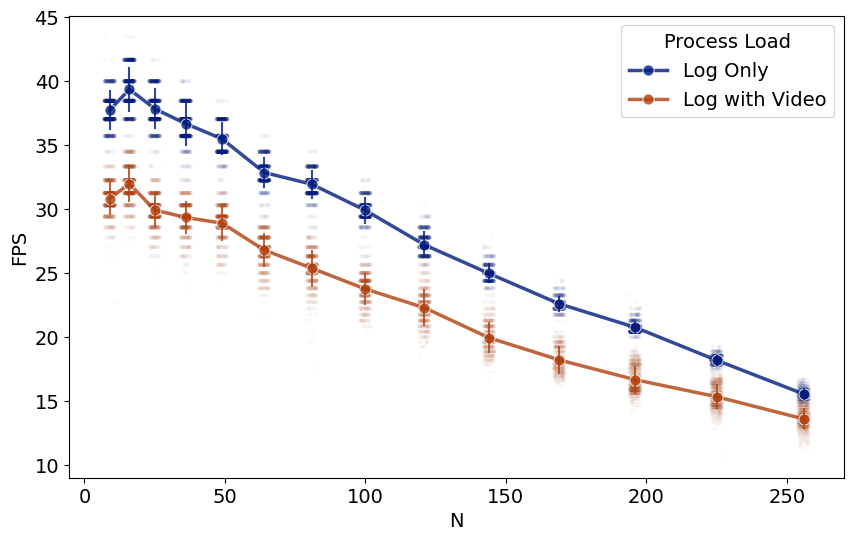

In [54]:
# plot all FPS vs N

log_combined_dfs = pd.concat([log_only_dfs, log_w_vid_dfs], ignore_index=True)

# df_to_plot = log_only_dfs.copy()
df_to_plot = log_w_vid_dfs.copy()
df_to_plot = log_combined_dfs.copy()


x_str = 'N'
# y_str = 'FPS'
y_str = 'FPS_calc'

# remove the FPS = 0 rows
df_to_plot = df_to_plot[df_to_plot['FPS'] > 0]
df_to_plot = df_to_plot[df_to_plot['FPS_calc'] > 0]

# remove the rows where N is 288
df_to_plot = df_to_plot[(df_to_plot['N'] != 288) & (df_to_plot['N'] != 290)]

df_to_plot['N'] = df_to_plot['N'].astype(int)

fig, ax = plt.subplots(figsize=(10, 6))
# increase the font size of the plot
plt.rcParams.update({'font.size': 14})


color_pal = sns.color_palette("Paired", 2)
color_pal = 'dark'
# color_pal = 'blue'

# sns.boxplot(data=df_to_plot, x='N', y='FPS', hue='log_str', palette=color_pal,
#             width=0.75, linewidth=0.5, showfliers=False, legend=False,
#             fill=False, gap = 0.1)
# # add the scatter points as well

# sns.stripplot(data=df_to_plot, x='N', y='FPS', hue='log_str', palette=color_pal, 
#               dodge=True, alpha=0.01, marker='o', legend=False, jitter=0.1, linewidth=0.0,
#               size=5, ax = ax
# )

# sns.boxenplot(
#     data=df_to_plot, x='N', y='FPS', hue='log_str', palette=color_pal,
#     width_method='linear', linewidth=0.25, showfliers=False, legend=False
# )


# sns.catplot(
#     data=df_to_plot, x='N', y='FPS', hue='log_str', 
#     palette=color_pal, # 'dark:b',
#     height=6, aspect=1.5,
# )

# if the number of log_str is 1, then do not use hue
# if len(df_to_plot['log_str'].unique()) == 1:
#     sns.pointplot(data=df_to_plot, x='N', y='FPS',
#                   color='b', dodge=True, markers='o', linestyles='-', linewidth=1,
#                   estimator=np.mean, errorbar='sd', linestyle='none')
# else:
#     sns.pointplot(data=df_to_plot, x='N', y='FPS', hue='log_str',
#               palette=color_pal, dodge=True, markers='o', linestyles='-', linewidth=1,
#               estimator=np.mean, errorbar='sd', linestyle='none')
    
sns.lineplot(
    data=df_to_plot, x='N', y=y_str, hue='log_str',
    marker='o',         # Use circle markers
    linestyle='-',      # Solid line
    errorbar=('sd'),      # Show standard deviation for error bars
    # err_style = 'band',  # Use band style for error bars
    err_style = 'bars',  # Use band style for error bars
    markersize=8,       # Increase marker size
    alpha=0.8,          # Slightly transparent lines and markers
    linewidth=2.5,      # Make the lines thicker
    palette=color_pal,  # Change the color palette
    dashes=False,       # Ensures solid lines even with hue (if you want all solid)
    ax=ax               # Ensure it plots on your defined axes
)

jitter_amount_n = 1.9 # Small jitter for discrete N
jitter_amount_fps = 0.2 # Small jitter for discrete FPS
df_to_plot['N_jittered'] = df_to_plot['N'] + np.random.uniform(-jitter_amount_n, jitter_amount_n, len(df_to_plot))
df_to_plot['FPS_jittered'] = df_to_plot['FPS'] + np.random.uniform(-jitter_amount_fps, jitter_amount_fps, len(df_to_plot))

sns.scatterplot(
    data=df_to_plot, x='N_jittered', y=y_str, hue='log_str',      # Color points by 'log_str'
    s=10,
    alpha=0.02,          # Set overall transparency for points
    marker='o',         # Use circle markers (can be 's', '^', 'X', 'D', etc.)
    edgecolor='None',  # Black border for markers
    linewidth=0.0,      # Thickness of the marker border
    palette=color_pal,  # Use a different color palette
    legend=False,      # Disable legend for scatter points
    ax=ax               # Plot on the defined axes
)


# plt.title('FPS vs N for Log Combined')
plt.xlabel('N')
plt.ylabel('FPS')

# change the legend values
if len(df_to_plot['log_str'].unique()) == 1:
    legend_labels = ['Log with Video']
else:
    legend_labels = ['Log Only', 'Log with Video']
handles, current_labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=legend_labels, title='Process Load', loc='upper right')


# plt.legend().remove()

# make a folder in the experiment directory to save the plots
plots_dir = os.path.join(experiment_dir, 'plots')
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# save the plot
plot_name = 'FPS_vs_N_log_combined'
plt.savefig(os.path.join(plots_dir, plot_name + '_2.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(plots_dir, plot_name + '_2.pdf'), dpi=300, bbox_inches='tight')

Position Accuracy

In [5]:
df = log_combined_dfs.copy()

# df = df[df['N'] == 256]
# print(df['N'].unique())
# df[df['N']==25]['positions']

# fig, ax = plt.subplots(figsize=(10, 6))

N_values = df['N'].unique()
log_str = df['log_str'].unique()
# print(experiments)

for N in tqdm.tqdm(N_values):
    print(f'Processing N = {N}')

    df_N = df[df['N'] == N]
    # print(df_experiment['N'].unique())    

    for log in log_str:
        df_N_log = df_N[df_N['log_str'] == log]
        # print(df_experiment_log['log_str'].unique())
        if len(df_N_log) == 0:
            print(f'No data for N = {N} and log_str = {log}')
            continue
        # get the position for each robot in the N
        positions_arr = []
        for index, row in df_N.iterrows():
            pos_data = np.vstack(row['positions'])
            positions_arr.append(pos_data)
            
            # plt.scatter(
            #     pos_data[:, 1], 
            #     pos_data[:, 2], 
            #     c=pos_data[:, 0], 
            #     alpha=0.01, 
            #     s=10, 
            #     edgecolor='None', 
            #     linewidth=0.0,
            #     label=f'N={N}'
            # )

        positions_arr = np.array(positions_arr)

        avg_positions = np.mean(positions_arr, axis=0)
        std_positions = np.std(positions_arr, axis=0)

        std_positions_tot = np.sqrt(std_positions[:, 1]**2 + std_positions[:, 2]**2)

        # print(std_positions_tot.shape)

        max_noise = np.max(std_positions_tot)
        avg_noise = np.mean(std_positions_tot)

        # add the average and std noise position to the total dataframe (df)
        df.loc[(df['N'] == N) & (df['log_str'] == log), 'avg_noise'] = avg_noise
        df.loc[(df['N'] == N) & (df['log_str'] == log), 'max_noise'] = max_noise

        if N == 256:
            print(f'Average noise for N = {N} and log_str = {log}: {avg_noise}')
            print(f'Max noise for N = {N} and log_str = {log}: {max_noise}')
        # df.loc[df['N'] == N, 'noise'] = [std_positions_tot]

        # ax.set_xlim(0, 1000)
        # ax.set_ylim(0, 1000)
        # ax.set_aspect('equal')

        # convert the positions to a 
        # sns.scatterplot(x=positions_arr[:, :, 1], y=positions_arr[:, :, 2], hue=positions_arr[:, :, 0])


# save the new dataframe to a parquet file
# output_file_log_combined = os.path.join(experiment_dir, 'unified_df_log_combined')
# df.to_parquet(output_file_log_combined + '.parquet', compression='zstd')


  0%|          | 0/1 [00:00<?, ?it/s]

Processing N = 100


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


In [6]:
df = log_combined_dfs.copy()

# df = df[df['N'] == 256]
# print(df['N'].unique())
# df[df['N']==25]['positions']

# fig, ax = plt.subplots(figsize=(10, 6))

N_values = df['N'].unique()
log_str = df['log_str'].unique()
control_values = df['control_var'].unique()
# print(experiments)

for control_val in tqdm.tqdm(control_values):
    print(f'Processing control_var = {control_val}')

    df_control = df[df['control_var'] == control_val]
    # print(df_experiment['N'].unique())    

    for log in log_str:
        df_control_log = df_control[df_control['log_str'] == log]
        # print(df_experiment_log['log_str'].unique())
        if len(df_control_log) == 0:
            print(f'No data for control_var = {control_val} and log_str = {log}')
            continue
        # get the position for each robot in the N
        positions_arr = []
        for index, row in df_control.iterrows():
            pos_data = np.vstack(row['positions'])
            positions_arr.append(pos_data)
            
            # plt.scatter(
            #     pos_data[:, 1], 
            #     pos_data[:, 2], 
            #     c=pos_data[:, 0], 
            #     alpha=0.01, 
            #     s=10, 
            #     edgecolor='None', 
            #     linewidth=0.0,
            #     label=f'N={N}'
            # )

        positions_arr = np.array(positions_arr)

        avg_positions = np.mean(positions_arr, axis=0)
        std_positions = np.std(positions_arr, axis=0)

        std_positions_tot = np.sqrt(std_positions[:, 1]**2 + std_positions[:, 2]**2)

        # print(std_positions_tot.shape)

        max_noise = np.max(std_positions_tot)
        avg_noise = np.mean(std_positions_tot)

        # add the average and std noise position to the total dataframe (df)
        df.loc[(df['control_var'] == control_val) & (df['log_str'] == log), 'avg_noise'] = avg_noise
        df.loc[(df['control_var'] == control_val) & (df['log_str'] == log), 'max_noise'] = max_noise



# save the new dataframe to a parquet file
# output_file_log_combined = os.path.join(experiment_dir, 'unified_df_log_combined')
# df.to_parquet(output_file_log_combined + '.parquet', compression='zstd')


 33%|███▎      | 32/98 [00:00<00:00, 170.46it/s]

Processing control_var = 0
Processing control_var = 1
Processing control_var = 2
Processing control_var = 3
Processing control_var = 4
Processing control_var = 5
Processing control_var = 6
Processing control_var = 7
Processing control_var = 8
Processing control_var = 9
Processing control_var = 10
Processing control_var = 11
Processing control_var = 12
Processing control_var = 13
Processing control_var = 14
Processing control_var = 15
Processing control_var = 17
Processing control_var = 18
Processing control_var = 19
Processing control_var = 21
Processing control_var = 22
Processing control_var = 23
Processing control_var = 24
Processing control_var = 26
Processing control_var = 27
Processing control_var = 28
Processing control_var = 29
Processing control_var = 30
Processing control_var = 31
Processing control_var = 32
Processing control_var = 33
Processing control_var = 34
Processing control_var = 36
Processing control_var = 37
Processing control_var = 39
Processing control_var = 40
Pr

 86%|████████▌ | 84/98 [00:00<00:00, 218.78it/s]

Processing control_var = 45
Processing control_var = 46
Processing control_var = 48
Processing control_var = 49
Processing control_var = 51
Processing control_var = 52
Processing control_var = 53
Processing control_var = 54
Processing control_var = 55
Processing control_var = 57
Processing control_var = 58
Processing control_var = 60
Processing control_var = 62
Processing control_var = 63
Processing control_var = 64
Processing control_var = 74
Processing control_var = 69
Processing control_var = 70
Processing control_var = 71
Processing control_var = 72
Processing control_var = 75
Processing control_var = 76
Processing control_var = 77
Processing control_var = 78
Processing control_var = 79
Processing control_var = 80
Processing control_var = 81
Processing control_var = 82
Processing control_var = 83
Processing control_var = 84
Processing control_var = 85
Processing control_var = 86
Processing control_var = 87
Processing control_var = 89
Processing control_var = 90
Processing control_v

100%|██████████| 98/98 [00:00<00:00, 212.91it/s]

Processing control_var = 67
Processing control_var = 73
Processing control_var = 88
Processing control_var = 93
Processing control_var = 35
Processing control_var = 59
Processing control_var = 68


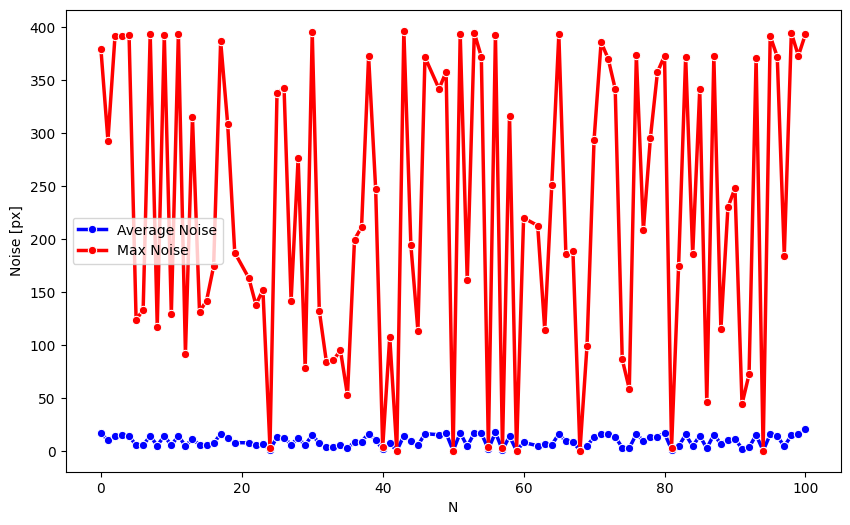

In [7]:
# lineplot the average noise vs N
fig, ax = plt.subplots(figsize=(10, 6))

df_to_plot = df.copy()
df_to_plot = df_to_plot[df_to_plot['N'] < 270]  # Exclude N < 270
# sns.lineplot(data=df_to_plot, x='N', y='avg_noise', marker='o', hue='log_str',
#              linestyle='-', linewidth=2.5, color='blue') # , label='Average Noise')
# sns.lineplot(data=df_to_plot, x='N', y='max_noise', marker='o', hue='log_str',
#              linestyle='-', linewidth=2.5, color='red') # , label='Max Noise')

# sns.lineplot(data=df_to_plot, x='N', y='avg_noise', marker='o',
#              linestyle='-', linewidth=2.5, color='blue', label='Average Noise')
# sns.lineplot(data=df_to_plot, x='N', y='max_noise', marker='o',
#              linestyle='-', linewidth=2.5, color='red', label='Max Noise')

sns.lineplot(data=df_to_plot, x='control_var', y='avg_noise', marker='o',
             linestyle='-', linewidth=2.5, color='blue', label='Average Noise')
sns.lineplot(data=df_to_plot, x='control_var', y='max_noise', marker='o',
             linestyle='-', linewidth=2.5, color='red', label='Max Noise')


plt.xlabel('N')
plt.ylabel('Noise [px]')


# save the plot
plot_name = 'Noise_vs_N_log_combined'
# plt.savefig(os.path.join(plots_dir, plot_name + '.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(plots_dir, plot_name + '.pdf'), dpi=300, bbox_inches='tight')

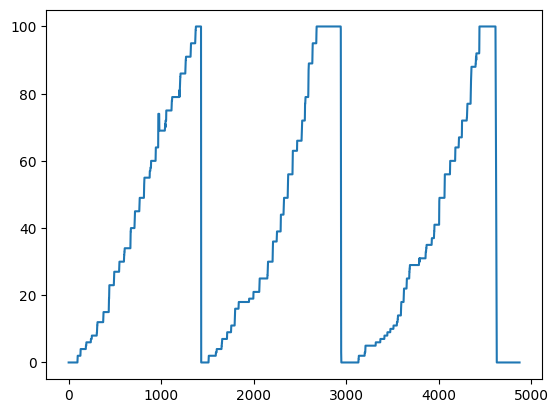

In [8]:
plt.plot(df['control_var'])

<class 'numpy.ndarray'>
(10, 10)
avg pitions shape: (100, 3)


/var/folders/vc/0rfzpd996v92fl5409tm8bb00000gn/T/ipykernel_12642/2626939228.py:27: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(positions_arr[:, :, 1], positions_arr[:, :, 2], color='k', marker='+', s=100, linewidth=0.05, edgecolor='black')
/var/folders/vc/0rfzpd996v92fl5409tm8bb00000gn/T/ipykernel_12642/2626939228.py:28: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(avg_positions[:, 1], avg_positions[:, 2], color='red', marker='x', s=100, linewidth=1, edgecolor='red')


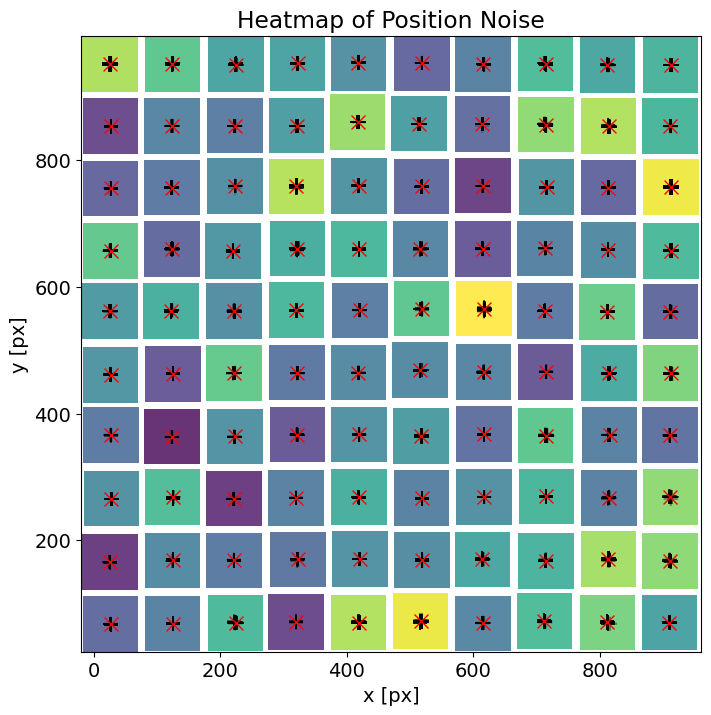

<Figure size 640x480 with 0 Axes>

In [31]:
# std_positions_tot = df[df['N'] == 256]['std_noise']
# print(std_positions_tot)
print(type(std_positions_tot))
print(std_positions_tot.shape)
#
fig, ax = plt.subplots(figsize=(8, 8)) 
grid_length = int(np.sqrt(len(std_positions_tot)))  # Assuming std_positions_tot is a square grid
# std_positions_tot = std_positions_tot.reshape((grid_length, grid_length))  # Reshape to a 2D array for visualization
# ax.imshow(std_positions_tot, aspect='auto', cmap='viridis', origin='lower')

print("avg pitions shape:", avg_positions.shape)
# plot the heatmap of noise (std_positions_tot) at each position of robots using (avg_positions)
scatter = plt.scatter(
    avg_positions[:, 1],  # x-coordinates
    avg_positions[:, 2],  # y-coordinates
    c=std_positions_tot,  # Color based on noise
    cmap='viridis',      # Choose a colormap
    s=1600,               # Base size of markers (adjust as needed)
    alpha=0.8,
    edgecolor='None',   # Add a black edge for better visibility
    linewidth=0.5,
    marker='s'
)

# plot a + sign at the average position of each robot
# 
plt.scatter(positions_arr[:, :, 1], positions_arr[:, :, 2], color='k', marker='+', s=100, linewidth=0.05, edgecolor='black')
plt.scatter(avg_positions[:, 1], avg_positions[:, 2], color='red', marker='x', s=100, linewidth=1, edgecolor='red')
# positions_arr

# plt.colorbar

plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Heatmap of Position Noise')
plt.axis('equal')
# plt.grid(True)
plt.show()

# save the figure
plt.savefig(os.path.join(plots_dir, 'heatmap_noise_positions.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(plots_dir, 'heatmap_noise_positions.pdf'), dpi=300, bbox_inches='tight')

# print(avg_positions)
# print(std_positions)
